# <b>Question 2.2</b>

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import sortedcontainers
import copy
%matplotlib inline

### <b> Part 1 - How many objects have one or more holes?</b>

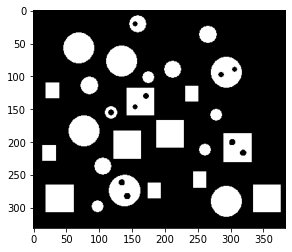

In [2]:
o = cv2.imread("../images/objects.png")
oG = cv2.cvtColor(o,cv2.COLOR_BGR2GRAY)
plt.imshow(oG,cmap='gray')

In [3]:
def padding(pic,k):
    padNum = math.floor(k/2)
    padPic = np.zeros((pic.shape[0]+(2*padNum),pic.shape[1]+(2*padNum)))
    padPic[padNum:padPic.shape[0]-padNum, padNum:padPic.shape[1]-padNum] = pic
    xStart = padNum
    xEnd = padPic.shape[0]-padNum
    yStart = padNum
    yEnd = padPic.shape[1]-padNum
    padPic[xStart:xEnd, yStart:yEnd] = pic
    return padPic

def dilate(img,k1,k2):
    k = max(k1,k2)
    padPic = padding(img,k)
    out = np.zeros_like(padPic)
    padNum = int(k/2)
    xStart = padNum
    xEnd = padPic.shape[0]-padNum
    yStart = padNum
    yEnd = padPic.shape[1]-padNum
    StructE = np.ones((k1,k2),dtype='uint8')
    for i in range(xStart,xEnd):
        for j in range(yStart,yEnd):
            vals = padPic[i-k1//2:i+k1//2+1,j-k2//2:j+k2//2+1]
            vals = vals*StructE
            out[i,j] = np.max(vals)
    out = out[xStart:xEnd,yStart:yEnd]
    return out


def erode(img,k1,k2):
    k = max(k1,k2)
    padPic = padding(img,k)
    out = np.zeros_like(padPic)
    padNum = int(k/2)
    xStart = padNum
    xEnd = padPic.shape[0]-padNum
    yStart = padNum
    yEnd = padPic.shape[1]-padNum
    StructE = np.ones((k1,k2),dtype='uint8')
    for i in range(xStart,xEnd):
        for j in range(yStart,yEnd):
            vals = padPic[i-k1//2:i+k1//2+1,j-k2//2:j+k2//2+1]
            vals = vals*StructE
            out[i,j] = np.min(vals)
    out = out[xStart:xEnd,yStart:yEnd]
    return out

In [4]:
# def floodFillTwoPass(img):
#     visit = np.zeros_like(img,dtype=np.int64)
#     objC = 0
#     r,c = img.shape
#     for i in range(r):
#         for j in range(c):
#             #Initial row(means no top pixel)
#             if i == 0:
#                 #First pixel(means no left pixel -> create new label
#                 if j == 0 and img[i,j] == 1:
#                     objC+=1
#                     visit[i,j] = objC
#                 else:
#                     #Check left pixel if it is part of foreground -> use prev label
#                     if img[i,j-1] == 1 and img[i,j]==1:
#                         visit[i,j] = visit[i,j-1]
#                     #IF left pixel is not part of fg -> create new label
#                     elif img[i,j]==1:
#                         objC+=1
#                         visit[i,j] = objC
#             else:
#                 #If upper pixel is filled -> use prev label
#                 if img[i,j] ==1 and j==0 and img[i-1,j]==1:
#                     print("hello")
#                     visit[i,j] = visit[i-1,j]
#                 elif img[i,j]==1 and j==0:
#                     objC+=1
#                     visit[i,j] = objC
#                 #Both top and left pixel then use minimum label value
#                 elif img[i,j]==1 and img[i-1,j]==1 and img[i,j-1]==1:
#                     l1 = visit[i-1,j]
#                     l2 = visit[i,j-1]
#                     lNew = min(l1,l2)
#                     visit[i,j] = lNew
#                 #Left and top background
#                 elif img[i,j]==1 and img[i-1,j]==0 and img[i,j-1]==0:
#                     objC+=1
#                     visit[i,j]=objC
#                 #Left is background and top is fg -> use prev pixel
#                 elif img[i,j]==1 and img[i-1,j]==1 and img[i,j-1]==0:
#                     visit[i,j] = visit[i-1,j]
#                 elif img[i,j]==1 and img[i-1,j]==0 and img[i,j-1]==1:
#                     visit[i,j] = visit[i,j-1]
#     return objC,visit

In [5]:
def filt(img,ker):
    r = img.shape[0]
    c = img.shape[1]
    out = img.copy()
    xS = 1
    xE = img.shape[0] - 1
    yS = 1
    yE = img.shape[1] - 1
    for i in range(xS,xE):
        for j in range(yS,yE):
            KxS = i - 1
            KxE = i + 1
            KyS = j - 1
            KyE = j + 1
            imgK = img[KxS:KxE+1,KyS:KyE+1]
            present = 1
            for a in range(3):
                for b in range(3):
                    if ker[a,b] == -1:
                        continue
                    elif ker[a,b] != imgK[a,b]:
                        present = 0
            if present == 1:
                out[i,j] = 0
    return out


In [6]:
def filtHitMiss(img,ker):
    r = img.shape[0]
    c = img.shape[1]
    out = img.copy()
    xS = 1
    xE = img.shape[0] - 1
    yS = 1
    yE = img.shape[1] - 1
    for i in range(xS,xE):
        for j in range(yS,yE):
            KxS = i - 1
            KxE = i + 1
            KyS = j - 1
            KyE = j + 1
            imgK = img[KxS:KxE+1,KyS:KyE+1]
            if ((imgK == ker).all()):
                out[i,j] = 1
            else:
                out[i,j] = 0
#             present = 1
#             for a in range(3):
#                 for b in range(3):
#                     if ker[a,b] == -1:
#                         continue
#                     elif ker[a,b] != imgK[a,b]:
#                         present = 0
#             if present == 1:
#                 out[i,j] = 0
    return out

In [7]:
def findRoot(ar, unionIt):
    if unionIt[ar] == ar:
        return ar
    else:
        unionIt[ar] = findRoot(unionIt[ar], unionIt)
        return unionIt[ar]
    
def unionSet(ar1, ar2, unionIt):
    val1 = findRoot(ar1,unionIt)
    val2 = findRoot(ar2,unionIt)
    minVal = min(val1,val2)
    maxVal = max(val1,val2)
    unionIt[maxVal] = minVal


    
    
def connComponents(im):
    next_label = 1;
    labels = np.zeros(im.shape, dtype=int)
    linked = [0]
    h, w = im.shape
    for row in range(h):
        for column in range(w):
            if im[row, column] != 0:
                neighbors = []
                if row > 0:
                    if im[row-1][column] == im[row, column]:
                        neighbors.append((row-1, column))
                if row > 0 and column + 1 < im.shape[1]:
                    if im[row-1, column+1] == im[row, column]:
                        neighbors.append((row-1, column+1))
                if row > 0 and column > 0:
                    if im[row-1, column-1] == im[row, column]:
                        neighbors.append((row-1, column-1))
                if column > 0:
                    if (im[row, column-1] == im[row, column]):
                        neighbors.append((row, column-1))

                if len(neighbors) == 0:
                    linked.append(next_label)
                    labels[row, column] = next_label
                    next_label += 1
                
                else:
                    L = [labels[r, c] for r, c in neighbors]
                    labels[row, column] = min(L)
                    for label in L:
                        unionSet(label, labels[row, column], linked)
                        
    for row in range(im.shape[0]):
        for column in range(im.shape[1]):
            if im[row, column] != 0:
                labels[row, column] = findRoot(labels[row, column], linked)
    return labels


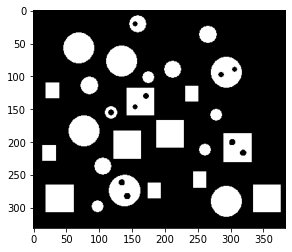

In [8]:
(T,binary_image)=cv2.threshold(oG,128,255,cv2.THRESH_BINARY)


plt.imshow(binary_image,cmap='gray')
plt.show()

binary_image=binary_image//255

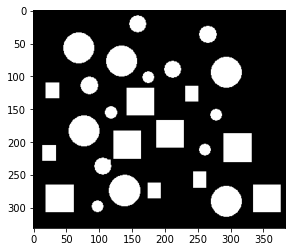

In [9]:
n_binary_image=erode(dilate(binary_image,7,9),7,9)
plt.imshow(n_binary_image,cmap='gray')

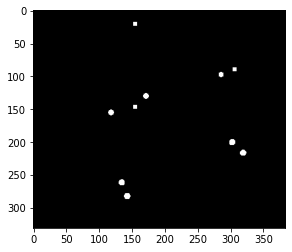

In [10]:
holePosition = dilate(erode(n_binary_image - binary_image,3,3),3,3)
plt.imshow(holePosition,cmap='gray')

In [11]:
adjMatrix = np.zeros(binary_image.shape)
r = binary_image.shape[0]
c = binary_image.shape[1]

countHimg = 0

def dfsIter(img,i,j):
    moveAround = np.array([[-1,0],  #Top
                  [0,-1],           #Left
                  [1,0],            #Down
                  [0,1]])           #Right
    for p in range(4):
        indexR = i + moveAround[p][0]
        indexC = j + moveAround[p][1]
        if indexR>=0 and indexR<img.shape[0]:
            if indexC>=0 and indexC<img.shape[1]:
                if adjMatrix[indexR,indexC] == 0 and img[indexR,indexC] == 1:
                    adjMatrix[indexR,indexC] = 1
                    dfsIter(img,indexR,indexC)
                    

In [12]:
for i in range(r):
    for j in range(c):
        if holePosition[i,j] == 1:
            if adjMatrix[i,j] == 0:
                countHimg +=1
            else:
                countHimg = countHimg
            dfsIter(n_binary_image,i,j)

In [13]:
onlyHoleFig = np.logical_and(binary_image,adjMatrix)

384


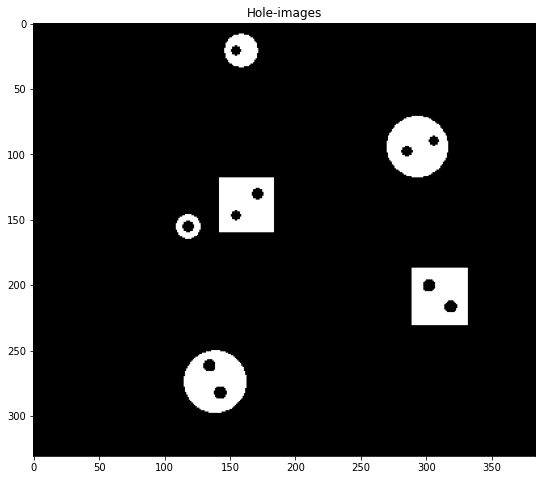

In [14]:
fig,axs = plt.subplots(1, 1,figsize=(9,9))
axs.imshow(onlyHoleFig,cmap='gray')
axs.set_title('Hole-images')
print(str(c))

### <b>Squares</b>

In [15]:
rectFilter = [[0,0,0],
              [1,  1,0],
              [1,  1,0]]
rectFilter = np.array(rectFilter)
applySq = filtHitMiss(binary_image,rectFilter)
count_Sq = 0
print(np.max(applySq))
print(applySq[applySq==1])
print(applySq.shape)

1
[1 1 1 1 1 1 1 1 1 1 1]
(331, 384)


In [16]:
adjMatrix = np.zeros(binary_image.shape)
r = applySq.shape[0]
c = applySq.shape[1]
print(r,c)

331 384


In [17]:
for i in range(r):
    for j in range(c):
        if applySq[i][j] == 1:
            count_Sq += (adjMatrix[i][j] == 0)
            dfsIter(binary_image,i,j)

Number of square images is:  11


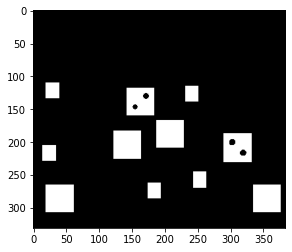

In [19]:
plt.imshow(adjMatrix,cmap='gray')
print("Number of square images is: ",count_Sq)

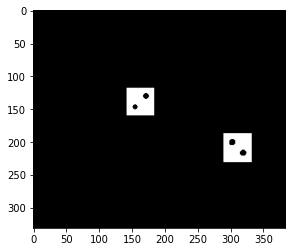

In [20]:
squareholeObj = np.logical_and(adjMatrix,onlyHoleFig)
plt.imshow(squareholeObj,cmap='gray')

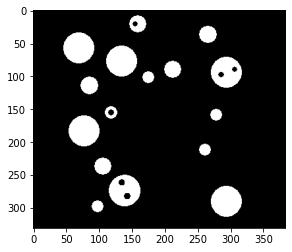

In [21]:
circleObjs = binary_image - adjMatrix
plt.imshow(circleObjs,cmap='gray')

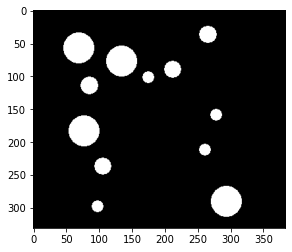

In [22]:
circleHole = np.logical_and(onlyHoleFig,circleObjs)
circleNoHole = circleObjs - circleHole
plt.imshow(circleNoHole,cmap='gray')